#### Load data

In [1]:
import os,sys
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [8]:
from scipy.optimize import minimize
sys.path.append('/home/ophilcox/EffectiveHalos/')
import EffectiveHalos as ph


In [9]:
z_ind = 0
z = [0,0.5,1,2,3][z_ind]
print("z = %.1f"%z)

z = 0.0


In [25]:
dat = np.load('all_sims_no_SSC_data_big_z=%s.npz'%z)
k3 = dat.f.k
Pk3 = dat.f.all_Pk_fid
m3=dat.f.mass_bins
m_av = 0.5*(m3[1:]+m3[:-1])
Nm3 = dat.f.halos_in_bin_fid
dat.close()

## Load PerturbedHalos module

cosm = ph.Cosmology(z,name='Quijote')
mf = ph.MassFunction(cosm,'Bhattacharya')
hp = ph.HaloPhysics(cosm,mf,halo_overdensity=200,npoints=300)
hm = ph.HaloModel(cosm,mf,hp,k3)

In [26]:
## Load Observed Biases
b1_spl = np.load('/home/ophilcox/HaloPower/all_b1_fine_spline.npy',allow_pickle=True)[z_ind]

## Optimize Power Spectrum Parameters
P_HM = lambda par: hm.halo_model(par[0],par[1])
mean_Pk = Pk3.mean(axis=0)
std_Pk = Pk3.std(axis=0)
ff = k3<0.8
to_min = lambda par: np.sum(((P_HM(par)[ff]-mean_Pk[ff])/std_Pk[ff])**2.)
x=minimize(to_min,[1.,1.])

cs2 = x.x[0]
R = x.x[1]
print("\nOptimal parameters: cs2 = %.2f R = %.2f\n"%(cs2,R))
PkL=cosm.compute_linear_power(k3)
P_NL = hm.non_linear_power(cs2,R)


Optimal parameters: cs2 = 9.25 R = 1.86



In [27]:
vol = 1000.**3.
cc = ph.CountsCovariance(cosm,mf,hp,k3,m3,vol,npoints=300)

In [28]:
ccInt = cc.NP_covariance(cs2, R, -1,-1,0,0)

In [32]:
ccInt, cc1h,cc2h,cc3h = cc._compute_intrinsic_NP_covariance(cs2, R, True)

In [65]:
R_ex = 4. # roughly R_lag of biggest halos
new2 = cc2h - cc2h[0]/(1.+(k3*2*R_ex)**4.)

new1 = cc1h - cc1h[0]/(1.+(k3*3*R_ex)**4.)

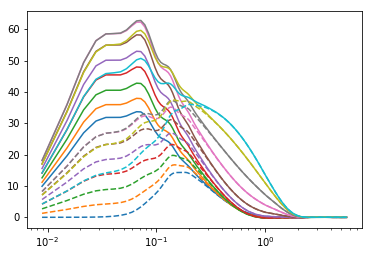

In [66]:
from matplotlib.colorbar import cm
cmap = cm.tab10
for i in range(10):
    plt.plot(k3,k3*cc2h[i],c=cmap(i/10.));
    plt.plot(k3,k3*new2[i],c=cmap(i/10.),ls='--')
plt.xscale('log')

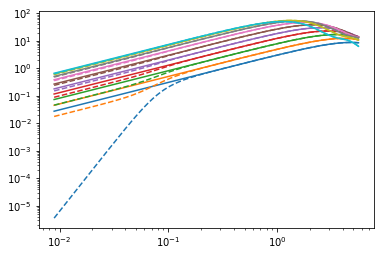

In [67]:
for i in range(10):
    plt.plot(k3,k3*cc1h[i],c=cmap(i/10.));
    plt.plot(k3,k3*new1[i],c=cmap(i/10.),ls='--')
plt.xscale('log')
plt.yscale('log')

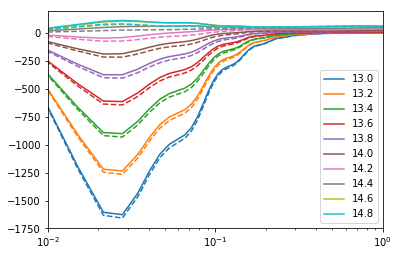

In [70]:
for i in range(10):
    plt.plot(k3,ccInt[i]*k3,label='%.1f'%np.log10(m_av[i]),c=cmap(i/10.))
    plt.plot(k3,k3*(new1[i]+new2[i]+cc3h[i]),c=cmap(i/10.),ls='--')
plt.xlim([0.01,1])
plt.legend();
plt.xscale('log')

In [ ]:
#### Test the mass function model and compare to data
bias_dat = np.load('all_b1_b2_bs2.npz')

iJ_02_obs = (bias_dat.f.b2*bias_dat.f.b0)[z_ind]
iJ_01_obs = (bias_dat.f.b1*bias_dat.f.b0)[z_ind]
iJ_0s2_obs = (bias_dat.f.bs2*bias_dat.f.b0)[z_ind]
iJ_00_obs = bias_dat.f.b0[z_ind]

I_11 = hm.mass_integrals.compute_I_11()
I_10 = hm.mass_integrals.compute_I_10()
iJ_20 = []
iJ_21 = []
iJ_01 = []
iJ_02 = []
iJ_11 = []
iJ_111 = []
iJ_12 = []
iJ_10 = []
iJ_00 = []
filt = k3<1
for i in range(len(m3)-1):
    mi = ph.MassIntegrals(cosm,mf,hp,k3[filt],min_logM=np.log10(m3[i]/cosm.h),max_logM=np.log10(m3[i+1]/cosm.h))
    iJ_20.append(mi.compute_I_20())
    iJ_21.append(mi.compute_I_21())
    iJ_01.append(mi.compute_I_01())
    iJ_02.append(mi.compute_I_02())
    iJ_11.append(mi.compute_I_11(False))
    iJ_111.append(mi.compute_I_111())
    iJ_12.append(mi.compute_I_12(False))
    iJ_00.append(mi.compute_I_00())
    iJ_10.append(mi.compute_I_10())
    
#### Compute covariances
covNmPk = np.matmul((Nm3-np.mean(Nm3,axis=0)).T,(Pk3-np.mean(Pk3,axis=0)))/(len(Nm3)-1.)
covNmNm = np.cov((Nm3-np.mean(Nm3,axis=0)).T)

m_av = 0.5*(m3[1:]+m3[:-1])

In [ ]:
#### Compute iJ_11 from the observed bias splines
from scipy.integrate import simps
iJ_11_spl = []
iJ_111_spl = []

for i in range(len(m3)-1):
    mi = ph.MassIntegrals(cosm,mf,hp,k3[filt],min_logM=np.log10(m3[i]/cosm.h),max_logM=np.log10(m3[i+1]/cosm.h))

    p = 1
    fourier_profiles = np.power(mi._compute_fourier_profile(),p)

    # Compute d(n(M))/d(log10(M))
    dn_dlogm = mi._compute_mass_function()

    # Define normalization to get correct unity (with Mpc/h and Msun/h units)
    norm = np.power(cosm.h,3.*float(p)-3.)

    bias1 = b1_spl(mi.m_h_grid)
    integ = dn_dlogm * fourier_profiles * bias1 * norm

    iJ_11_spl.append(simps(integ,mi.logM_grid,axis=1))
    iJ_111_spl.append(simps(integ*bias1,mi.logM_grid,axis=1))
iJ_11_spl = np.asarray(iJ_11_spl)
iJ_111_spl = np.asarray(iJ_111_spl)

#### Compute remaining 2-halo term from FAST-PT

In [ ]:
import fastpt as FASTPT
from scipy.interpolate import InterpolatedUnivariateSpline

In [ ]:
min_k = np.max([np.min(k3),1e-4]) # setting minimum to avoid zero errors
max_k = np.max(k3)
kh_interp = np.logspace(np.log10(min_k)-0.5,np.log10(max_k)+0.5,1e4)
hm2 = ph.HaloPower(cosm,mf,hp,kh_interp)
# Compute the one-loop spectrum using FAST-PT
fastpt = FASTPT.FASTPT(kh_interp,to_do=['dd_bias'],n_pad=len(kh_interp)*3);
Wk = hm2._compute_smoothing_function(R)
out=fastpt.one_loop_dd_bias((cosm.compute_linear_power(kh_interp)*Wk).copy(),C_window=0.65,P_window=[0.25,0.25])
PF2P_power = out[2]/2.
PFs2P_power = out[4]/2.
PF2P_int = InterpolatedUnivariateSpline(kh_interp,PF2P_power*Wk)
PFs2P_int = InterpolatedUnivariateSpline(kh_interp,PFs2P_power*Wk)

In [6]:
iJ_0s2 = -4./7.*(np.asarray(iJ_01)-np.asarray(iJ_00))
iJ_1s2 = -4./7.*(np.asarray(iJ_11)-np.asarray(iJ_10))

NameError: name 'iJ_01' is not defined

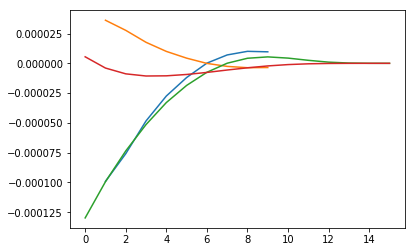

In [12]:
plt.plot(iJ_02_obs)
plt.plot(iJ_0s2_obs)
plt.plot(iJ_02)
plt.plot(iJ_0s2)

In [13]:
iJ_02_obs = np.asarray(iJ_02_obs)
iJ_02 = np.asarray(iJ_02)
iJ_0s2_obs = np.asarray(iJ_0s2_obs)
iJ_0s2 = np.asarray(iJ_0s2)
iJ_20 = np.asarray(iJ_20)
iJ_00_obs = np.asarray(iJ_00_obs)
iJ_00 = np.asarray(iJ_00)
iJ_12 = np.asarray(iJ_12)
iJ_11_spl = np.asarray(iJ_11_spl)
filt2 = np.where(np.isfinite(iJ_0s2_obs))
    
def compute_model(cs2,R,use_s2=True):

    P_NL = hm.non_linear_power(cs2,R)
    Wk = hm2._compute_smoothing_function(R)
    out=fastpt.one_loop_dd_bias((cosm.compute_linear_power(kh_interp)*Wk).copy(),C_window=0.65,P_window=[0.25,0.25])
    PF2P_power = out[2]/2.
    PFs2P_power = out[4]/2.
    PF2P_int = InterpolatedUnivariateSpline(kh_interp,PF2P_power*Wk)
    PFs2P_int = InterpolatedUnivariateSpline(kh_interp,PFs2P_power*Wk)
    model = np.zeros((len(filt2[0]),len(k3[filt])))
    model += (iJ_02_obs[filt2].reshape(-1,1))*(I_11[filt]**2.*hm._compute_smoothing_function(R)[filt]**4.*PkL[filt]**2.).reshape(1,-1)
    if use_s2: 
        model += (2./3.*iJ_0s2_obs[filt2]).reshape(-1,1)*(I_11[filt]**2.*hm._compute_smoothing_function(R)[filt]**4.*PkL[filt]**2.).reshape(1,-1)
    model += (iJ_11_spl[filt2])*(2.*I_11[filt]*P_NL[filt]).reshape(1,-1)
    model += (iJ_12[filt2]*iJ_02_obs[filt2].reshape(-1,1)/iJ_02[filt2].reshape(-1,1))*2.*(I_11[filt]*PF2P_int(k3[filt])).reshape(1,-1)
    if use_s2: 
        model += (iJ_12[filt2]*iJ_0s2_obs[filt2].reshape(-1,1)/iJ_0s2[filt2].reshape(-1,1))*2.*(I_11[filt]*PFs2P_int(k3[filt])).reshape(1,-1)
    model += iJ_20[filt2]*iJ_00_obs[filt2].reshape(-1,1)/iJ_00[filt2].reshape(-1,1)
    
    return model

In [14]:
from mcfit import P2xi,xi2P
from scipy.interpolate import InterpolatedUnivariateSpline,interp2d,interp1d

In [15]:
## Define exclusion functions

Theta_exc_R = lambda R: 4.*np.pi*R**2./k3[filt].reshape(-1,1)*spherical_jn(1,k3[filt].reshape(-1,1)*R)
V_exc = lambda R: 4.*np.pi*R**3./3.

In [16]:
from scipy.interpolate import interp2d,interp1d

#### Compute the convolution of $P$ and $\Theta$
This is in $\mathrm{Mpc}/h$-type units

In [17]:
kk = np.logspace(-4,1,10000)
hp2 = ph.HaloPower(cosm,mf,hp,kk)
pp=hp2.non_linear_power(cs2,R)
r,xi = P2xi(kk)(pp)
RR = np.linspace(0,200,1000)
xi = np.vstack([xi for _ in range(len(RR))])
xi[r.reshape(1,-1)>RR.reshape(-1,1)]=0.
kk,pp = xi2P(r)(xi)
pp_theta = interp2d(kk,RR,pp)

How do we pass in MassIntegrals parameters?
sensibly set default n_mass
we should shunt a lot of these definitions into the NonLinearPower class? or Cov class?
find better place to store these parameters
Should make sure this can take a float input also
need to test these hyperparameters
Should make sure this can take a float input also
Should make sure this can take a float input also
should add hyperparameters here?
need nice way of importing FASTPT from user installation
need nice way of setting interpolation parameters?
remove interpolation parameters??
need to test these hyperparameters
Should make sure this can take a float input also
Non-linear BAO damping scale = 5.47 Mpc/h
add ir parameters?
should carry over parameters here - or initialize them in the class
need nice way of importing FASTPT from user installation
need nice way of setting interpolation parameters?
remove interpolation parameters??
need to test these hyperparameters
Should make sure this can take a float input 

/home/ophilcox/.conda/envs/ptenv/lib/python2.7/site-packages/mcfit/mcfit.py:125: UserWarning: The default value of lowring has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of lowring has been changed to False, "
/home/ophilcox/.conda/envs/ptenv/lib/python2.7/site-packages/mcfit/mcfit.py:219: UserWarning: The default value of extrap has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of extrap has been changed to False, "


##### Units
- Work in $h^{-1}$ units in general here
- We need factor of $h^{3\alpha-3}$ for the $n(m)\left(\frac{m}{\bar\rho}\right)^\alpha$ factor.
- However, if we define $M$ in $h^{-1}M_\odot$ units, we must convert to physical units and back again to get $R$ in Mpc/$h$ units. Then we get $V_{mm'}$ and $\Theta_{mm'}$ in $(\mathrm{Mpc}/h)^3$ units (so they don't need extra normalizations). $P\ast\Theta$ and $S^2$ should be fine since they're defined from $\xi$ in $\mathrm{Mpc}/h$-type units.
- Thus we only need $h^{3\alpha-3}$ factor from the usual integral plus careful definition of $R_\mathrm{ex}$.

In [34]:
## Compute the $S^2(R_{mm'})$ function using $\mathrm{Mpc}/h$ units
from scipy.special import spherical_jn

# First use linear theory
kk = np.logspace(-4,1,10000)
hm2 = ph.HaloPower(cosm,mf,hp,kk)
RR = np.linspace(0,500,3000).reshape(-1,1)
sigRL = simps(hm2.non_linear_power(cs2,R,'Linear',0,1,0)*kk**2./(2.*np.pi**2.)*4.*np.pi*spherical_jn(1,kk*RR)/kk*RR**2.,kk,axis=1)
sigL_int = interp1d(RR.ravel(),sigRL)

# Now use non-linear theory
sigRNL = simps(hm2.non_linear_power(cs2,R)*kk**2./(2.*np.pi**2.)*4.*np.pi*spherical_jn(1,kk*RR)/kk*RR**2.,kk,axis=1)
sigNL_int = interp1d(RR.ravel(),sigRNL)

How do we pass in MassIntegrals parameters?
sensibly set default n_mass
we should shunt a lot of these definitions into the NonLinearPower class? or Cov class?
find better place to store these parameters
Should make sure this can take a float input also
need to test these hyperparameters
Should make sure this can take a float input also
Should make sure this can take a float input also
should add hyperparameters here?
need nice way of importing FASTPT from user installation
need nice way of setting interpolation parameters?
remove interpolation parameters??
need to test these hyperparameters
Should make sure this can take a float input also
Non-linear BAO damping scale = 5.47 Mpc/h
add ir parameters?
should carry over parameters here - or initialize them in the class
need nice way of importing FASTPT from user installation
need nice way of setting interpolation parameters?
remove interpolation parameters??
need to test these hyperparameters
Should make sure this can take a float input 

In [35]:
### Compute models
cov_model_3h = np.zeros((len(m3)-1,len(k3[filt])))
cov_model_2h = np.zeros((len(m3)-1,len(k3[filt])))
cov_model_2h2 = np.zeros((len(m3)-1,len(k3[filt])))
cov_model_2h3 = np.zeros((len(m3)-1,len(k3[filt])))
cov_model_1h = np.zeros((len(m3)-1,len(k3[filt])))

# Can use b_s2 bias optionally
use_bs2 = False
obs_bias = False

## OPTION 1: Observed Biases
if obs_bias:
    for i in range(len(iJ_02)-6):

        cov_model_3h[i] = I_11[filt]**2.*(iJ_02_obs[i]+use_bs2*2./3.*iJ_0s2_obs[i])*hm._compute_smoothing_function(R)[filt]**4.*PkL[filt]**2.
        cov_model_2h[i] = 2.*I_11[filt]*iJ_11_spl[i]*P_NL[filt]
        cov_model_2h[i] += 2.*I_11[filt]*(iJ_12[i]*iJ_02_obs[i]/iJ_02[i])*PF2P_int(k3[filt])
        if use_bs2: cov_model_2h[i] += 2.*I_11[filt]*(iJ_1s2[i]*iJ_0s2_obs[i]/iJ_0s2[i])*PFs2P_int(k3[filt])

        cov_model_1h[i] = 1.*iJ_20[i]*iJ_00_obs[i]/iJ_00[i]

## OPTION 2: Model Biases
else:
    for i in range(len(iJ_02)):

        cov_model_3h[i] = I_11[filt]**2.*(iJ_02[i]+use_bs2*2./3.*iJ_0s2[i])*hm._compute_smoothing_function(R)[filt]**4.*PkL[filt]**2.

        cov_model_2h[i] = 2.*I_11[filt]*iJ_11[i]*P_NL[filt]
        cov_model_2h[i] += 2.*I_11[filt]*iJ_12[i]*PF2P_int(k3[filt])
        if use_bs2: cov_model_2h[i] += 2.*I_11[filt]*iJ_1s2[i]*PFs2P_int(k3[filt])

        cov_model_1h[i] = 1.*iJ_20[i]

In [49]:
iK_Theta_01 = []
iK_S2_01 = []
#iK_S2_00 = []
iK_V_11 = []
iK_Theta_10 = []
iK_V_20 = []
iK_S2_21 = []
iK_PTheta_11 = []

# Higher order bias terms
iK_S2_12 = []
iK_V_02 = []

for bin_index in range(len(m_av)):
    mi2 = ph.MassIntegrals(cosm,mf,hp,k3[filt],min_logM=np.log10(m_av[bin_index]/cosm.h))
    dn_dlogm = mi2._compute_mass_function() 
    
    b_m = mi2._compute_linear_bias()
    b2_m = mi2._compute_second_order_bias()
    
    m_u_m = mi2._compute_fourier_profile()
    
    # need a normalization factor for and m/rho u(k|m) factor and for V_exm/Theta functions
    norm0 = np.power(cosm.h,3.*float(0)-3.)
    norm1 = np.power(cosm.h,3.*float(1)-3.)
    norm2 = np.power(cosm.h,3.*float(2)-3.)
    
    odelta = 1.
    R_ex = 0.
    alpha = 0.55
    
    # Compute exclusion radius in Mpc/h
    
    R_ex += cosm.h*np.power(3.*(m_av[bin_index]/cosm.h)/(4.*np.pi*cosm.rhoM*odelta),1./3.)
    R_ex += cosm.h*np.power(3.*(mi2.m_h_grid/cosm.h)/(4.*np.pi*cosm.rhoM*odelta),1./3.)
    R_ex = R_ex.reshape(1,-1)*alpha
    
    # Now the below quantities are already in (Mpc/h)^3 units
    V_exM = V_exc(R_ex)
    Theta_exM = Theta_exc_R(R_ex)
    pp_Theta_M = pp_theta(k3[filt],R_ex.ravel()).T
    S2L_M = sigL_int(R_ex)
    S2NL_M = sigNL_int(R_ex)
    
    # Now compute integrals
    iK_Theta_01.append(simps(dn_dlogm*b_m*Theta_exM*norm0,mi2.logM_grid,axis=1))
    iK_S2_01.append(simps(dn_dlogm*b_m*S2L_M*norm0,mi2.logM_grid,axis=1))
    iK_V_11.append(simps(dn_dlogm*b_m*V_exM*m_u_m*norm1,mi2.logM_grid,axis=1))
    iK_Theta_10.append(simps(dn_dlogm*m_u_m*Theta_exM*norm1,mi2.logM_grid,axis=1))
    iK_V_20.append(simps(dn_dlogm*m_u_m**2*V_exM*norm2,mi2.logM_grid,axis=1))
    iK_S2_21.append(simps(dn_dlogm*b_m*m_u_m**2*S2NL_M*norm2,mi2.logM_grid,axis=1))
    iK_PTheta_11.append(simps(dn_dlogm*b_m*m_u_m*pp_Theta_M*norm1,mi2.logM_grid,axis=1))
    
    iK_S2_12.append(simps(dn_dlogm*b2_m*m_u_m*S2L_M*norm1,mi2.logM_grid,axis=1))
    iK_V_02.append(simps(dn_dlogm*b2_m*V_exM*norm0,mi2.logM_grid,axis=1))

sensibly set default n_mass
we should shunt a lot of these definitions into the NonLinearPower class? or Cov class?
find better place to store these parameters
sensibly set default n_mass
we should shunt a lot of these definitions into the NonLinearPower class? or Cov class?
find better place to store these parameters
sensibly set default n_mass
we should shunt a lot of these definitions into the NonLinearPower class? or Cov class?
find better place to store these parameters
sensibly set default n_mass
we should shunt a lot of these definitions into the NonLinearPower class? or Cov class?
find better place to store these parameters
sensibly set default n_mass
we should shunt a lot of these definitions into the NonLinearPower class? or Cov class?
find better place to store these parameters
sensibly set default n_mass
we should shunt a lot of these definitions into the NonLinearPower class? or Cov class?
find better place to store these parameters
sensibly set default n_mass
we should sh

In [50]:
cov_ex_3h = np.zeros((len(m3)-1,len(k3[filt])))
cov_ex_2h = np.zeros((len(m3)-1,len(k3[filt])))
cov_ex_1h = np.zeros((len(m3)-1,len(k3[filt])))

cov_ex_simple_2h = np.zeros((len(m3)-1,len(k3[filt])))
cov_ex_simple_1h = np.zeros((len(m3)-1,len(k3[filt])))

cov_new_1 = np.zeros((len(m3)-1,len(k3[filt])))
cov_new_2 = np.zeros((len(m3)-1,len(k3[filt])))

b2_ex = False # use second-order bias here?

if obs_bias:
    for i in range(len(m_av)-6):
        cov_ex_3h[i] = -2.*iJ_01_obs[i]*I_11[filt]**2.*iK_Theta_01[i]*PkL[filt]**2.*hm._compute_smoothing_function(R)[filt]**4.

        cov_ex_2h[i] = -2.*iJ_10[i]*iJ_00_obs[i]/iJ_00[i]*I_11[filt]*iK_Theta_01[i]*P_NL[filt]
        cov_ex_2h[i] += + 2.*iJ_111_spl[i]*I_11[filt]*iK_S2_01[i]*PkL[filt]*hm._compute_smoothing_function(R)[filt]
        cov_ex_2h[i] += -2.*I_11[filt]*iJ_00_obs[i]*iK_V_11[i]*P_NL[filt]
        cov_ex_2h[i] += -2.*I_11[filt]*iJ_01_obs[i]*iK_Theta_10[i]*P_NL[filt]

        cov_ex_1h[i] += -iJ_00_obs[i]*iK_V_20[i]
        cov_ex_1h[i] += -iJ_01_obs[i]*iK_S2_21[i]
        cov_ex_1h[i] += -2.*iJ_10[i]*iJ_00_obs[i]/iJ_00[i]*iK_Theta_10[i]
        cov_ex_1h[i] += -2.*iJ_11_spl[i]*iK_PTheta_11[i]

        ## Just the Poisson terms
        cov_ex_simple_2h[i] += -2.*I_11[filt]*iJ_00_obs[i]*iK_V_11[i]*P_NL[filt]
        cov_ex_simple_2h[i] += -2.*I_11[filt]*iJ_01_obs[i]*iK_Theta_10[i]*P_NL[filt]

        cov_ex_simple_1h[i] += -iJ_00_obs[i]*iK_V_20[i]
        cov_ex_simple_1h[i] += -iJ_01_obs[i]*iK_S2_21[i]
        
        ## Second order bias terms (just using Poisson-2h tems and ignoring small 1-h term)
        if b2_ex:
            
            raise Exception('not all terms implemented!')
            cov_ex_2h[i] += -2.*iJ_02_obs[i]*I_11[filt]*iK_PTheta_11[i]*PkL[filt]*hm._compute_smoothing_function(R)[filt]**2.
            cov_ex_2h[i] += -2.*iJ_01_obs[i]*I_11[filt]*iK_S2_12[i]*PkL[filt]*hm._compute_smoothing_function(R)[filt]**2
            
else:
    for i in range(len(m_av)):
        cov_ex_3h[i] = -2.*iJ_01[i]*I_11[filt]**2.*iK_Theta_01[i]*PkL[filt]**2.*hm._compute_smoothing_function(R)[filt]**4.

        cov_ex_2h[i] = -2.*iJ_10[i]*I_11[filt]*iK_Theta_01[i]*P_NL[filt]
        cov_ex_2h[i] += + 2.*iJ_111[i]*I_11[filt]*iK_S2_01[i]*PkL[filt]*hm._compute_smoothing_function(R)[filt]
        cov_ex_2h[i] += -2.*I_11[filt]*iJ_00[i]*iK_V_11[i]*P_NL[filt]
        cov_ex_2h[i] += -2.*I_11[filt]*iJ_01[i]*iK_Theta_10[i]*P_NL[filt]

        cov_ex_1h[i] += -iJ_00[i]*iK_V_20[i]
        cov_ex_1h[i] += -iJ_01[i]*iK_S2_21[i]
        cov_ex_1h[i] += -2.*iJ_10[i]*iK_Theta_10[i]
        cov_ex_1h[i] += -2.*iJ_11[i]*iK_PTheta_11[i]

        cov_ex_simple_2h[i] += -2.*I_11[filt]*iJ_00[i]*iK_V_11[i]*P_NL[filt]
        cov_ex_simple_2h[i] += -2.*I_11[filt]*iJ_01[i]*iK_Theta_10[i]*P_NL[filt]

        cov_ex_simple_1h[i] += -iJ_00[i]*iK_V_20[i]
        cov_ex_simple_1h[i] += -iJ_01[i]*iK_S2_21[i]
        
        if b2_ex:
            cov_ex_3h[i] += -iJ_00[i]*iK_V_02[i]*I_11[filt]**2*PkL[filt]**2.*hm._compute_smoothing_function(R)[filt]**4.
            
            raise Exception('not all terms implemented!')
            cov_ex_2h[i] += -2.*iJ_02[i]*I_11[filt]*iK_PTheta_11[i]*PkL[filt]*hm._compute_smoothing_function(R)[filt]**2.
            cov_ex_2h[i] += -2.*iJ_01[i]*I_11[filt]*iK_S2_12[i]*PkL[filt]*hm._compute_smoothing_function(R)[filt]**2

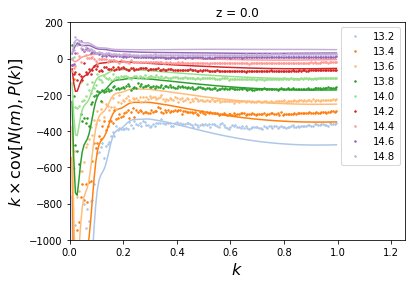

In [51]:
filt = k3<1
cmap = cm.tab20
plt.figure()
for i in range(1,10):
    plt.plot(k3[filt],m3[i]**0*(covNmPk[i,filt])*k3[filt],label="%.1f"%np.log10(m_av[i]),c=cmap(i/20.),marker='.',
             ls='',ms=3)
    cov_ex = cov_ex_3h[i]+cov_ex_2h[i]+cov_ex_1h[i]
    #cov_ex = cov_ex_simple_2h[i]+cov_ex_simple_1h[i]
    cov_norm = cov_model_3h[i]+cov_model_2h[i]+cov_model_1h[i]
    model = (cov_ex+cov_norm)
    plt.plot(k3[filt],m3[i]**0*model*k3[filt],
             c=cmap(i/20.))

plt.ylabel(r'$k\times\mathrm{cov}\left[N(m),P(k)\right]$',fontsize=16);
plt.xlabel(r'$k$',fontsize=16);
plt.legend()
plt.xlim([0,1.25])
plt.ylim([-1000,200])
plt.title('z = %.1f'%z);
#plt.ylim([-2e16,1e16]);

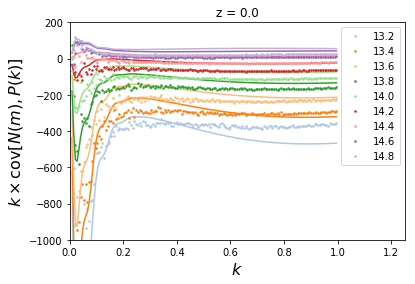

In [33]:
filt = k3<1
cmap = cm.tab20
plt.figure()
for i in range(1,10):
    plt.plot(k3[filt],m3[i]**0*(covNmPk[i,filt])*k3[filt],label="%.1f"%np.log10(m_av[i]),c=cmap(i/20.),marker='.',
             ls='',ms=3)
    cov_ex = cov_ex_3h[i]+cov_ex_2h[i]+cov_ex_1h[i]
    #cov_ex = cov_ex_simple_2h[i]+cov_ex_simple_1h[i]
    cov_norm = cov_model_3h[i]+cov_model_2h[i]+cov_model_1h[i]
    model = (cov_ex+cov_norm)
    plt.plot(k3[filt],m3[i]**0*model*k3[filt],
             c=cmap(i/20.))

plt.ylabel(r'$k\times\mathrm{cov}\left[N(m),P(k)\right]$',fontsize=16);
plt.xlabel(r'$k$',fontsize=16);
plt.legend()
plt.xlim([0,1.25])
plt.ylim([-1000,200])
plt.title('z = %.1f'%z);
#plt.ylim([-2e16,1e16]);

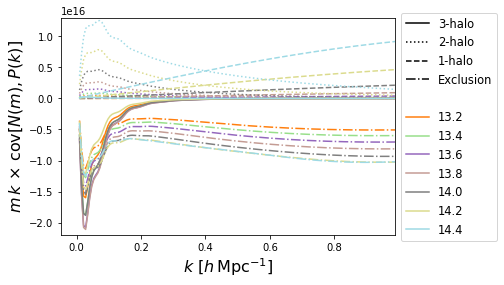

In [26]:
fig,ax=plt.subplots()

for i in range(1,8):
    #plt.plot(k3[filt],m3[i]*covNmPk[i,filt]*k3[filt]**2.,label="%.1f"%np.log10(m_av[i]),c=cmap(i/7.),marker='.',
    #         ls='',ms=3)
    ax.plot(k3[filt],m3[i]*(cov_model_3h[i])*k3[filt],
             c=cmap(i/7.),ls='-')
    ax.plot(k3[filt],m3[i]*(cov_model_2h[i])*k3[filt],
             c=cmap(i/7.),ls=':')
    ax.plot(k3[filt],m3[i]*(cov_model_1h[i])*k3[filt],
             c=cmap(i/7.),ls='--')
    ax.plot(k3[filt],m3[i]*(cov_ex_3h[i]+cov_ex_2h[i]+cov_ex_1h[i])*k3[filt],
             c=cmap(i/7.),ls='-.')

a=plt.plot(0,0,ls='-',label='3-halo',c='k')
b=plt.plot(0,0,ls=':',label='2-halo',c='k')
c=plt.plot(0,0,ls='--',label='1-halo',c='k')
d=plt.plot(0,0,ls='-.',label='Exclusion',c='k')
plt.plot(0,0,ls='',c='w',label='  ')
plt.ylabel(r'$m\,k\,\times\,\mathrm{cov}\left[N(m),P(k)\right]$',fontsize=16);
plt.xlabel(r'$k$ [$h\,\mathrm{Mpc}^{-1}$]',fontsize=16);


for i in range(1,8):
    plt.plot(m3[i],label='%.1f'%np.log10(m_av[i]),c=cmap(i/7.))
plt.legend(bbox_to_anchor=(1,1.05),fontsize=11.5)
plt.xlim([-0.05,0.99])
plt.ylim([-2.2e16,1.3e16]);
plt.savefig('/home/ophilcox/HaloPower/cov_breakdown_z0.pdf',bbox_inches='tight')

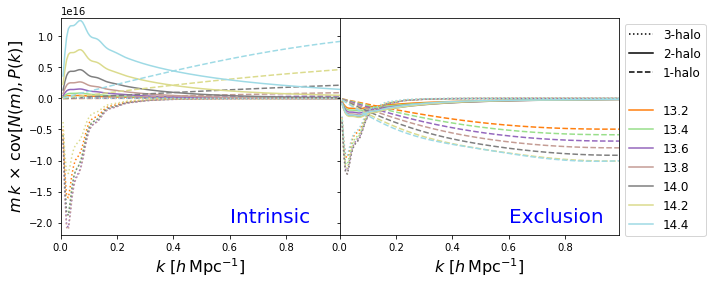

In [60]:
fig,ax=plt.subplots(1,2,figsize=(10,4),sharey=True)

for i in range(1,8):
    #plt.plot(k3[filt],m3[i]*covNmPk[i,filt]*k3[filt]**2.,label="%.1f"%np.log10(m_av[i]),c=cmap(i/7.),marker='.',
    #         ls='',ms=3)
    ax[0].plot(k3[filt],m3[i]*(cov_model_3h[i])*k3[filt],
             c=cmap(i/7.),ls=':')
    ax[0].plot(k3[filt],m3[i]*(cov_model_2h[i])*k3[filt],
             c=cmap(i/7.),ls='-')
    ax[0].plot(k3[filt],m3[i]*(cov_model_1h[i])*k3[filt],
             c=cmap(i/7.),ls='--')
    ax[1].plot(k3[filt],m3[i]*(cov_ex_3h[i])*k3[filt],
             c=cmap(i/7.),ls=':')
    ax[1].plot(k3[filt],m3[i]*(cov_ex_2h[i])*k3[filt],
             c=cmap(i/7.),ls='-')
    ax[1].plot(k3[filt],m3[i]*(cov_ex_1h[i])*k3[filt],
             c=cmap(i/7.),ls='--')

a=plt.plot(0,0,ls=':',label='3-halo',c='k')
b=plt.plot(0,0,ls='-',label='2-halo',c='k')
c=plt.plot(0,0,ls='--',label='1-halo',c='k')
plt.plot(0,0,ls='',c='w',label='  ')
ax[0].set_ylabel(r'$m\,k\,\times\,\mathrm{cov}\left[N(m),P(k)\right]$',fontsize=16);
ax[0].set_xlabel(r'$k$ [$h\,\mathrm{Mpc}^{-1}$]',fontsize=16);
ax[1].set_xlabel(r'$k$ [$h\,\mathrm{Mpc}^{-1}$]',fontsize=16);


ax[0].text(0.6,-2e16,'Intrinsic',color='b',fontsize=20)
ax[1].text(0.6,-2e16,'Exclusion',color='b',fontsize=20)
for i in range(1,8):
    plt.plot(m3[i],label='%.1f'%np.log10(m_av[i]),c=cmap(i/7.))
plt.legend(bbox_to_anchor=(1,1),fontsize=12)
ax[0].set_xlim([0.0,0.99])
ax[1].set_xlim([0.0,0.99])
plt.ylim([-2.2e16,1.3e16]);
plt.subplots_adjust(wspace=0.)
plt.savefig('/home/ophilcox/HaloPower/cov_breakdown_z0_v2.pdf',bbox_inches='tight')

(-2e-05, 5e-05)

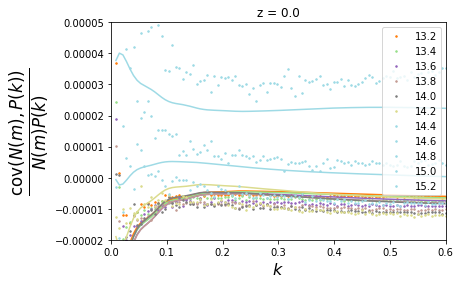

In [24]:
plt.figure()
for i in range(1,12):
    plt.plot(k3[filt],covNmPk[i,filt]/Pk3.mean(axis=0)[filt]/Nm3.mean(axis=0)[i],label="%.1f"%np.log10(m_av[i]),c=cmap(i/7.),marker='.',
             ls='',ms=3)
    exc_cov = (cov_ex_3h[i]+cov_ex_2h[i]+cov_ex_1h[i])
    #exc_cov = (cov_ex_3h[i]+cov_ex_2h[i]+cov_ex_1h[i])
    cov = (cov_model_3h[i]+cov_model_2h[i]+cov_model_1h[i])
    plt.plot(k3[filt],(exc_cov+cov)/Pk3.mean(axis=0)[filt]/Nm3.mean(axis=0)[i],#*k3[filt],
             c=cmap(i/7.))

plt.ylabel(r'$\frac{\mathrm{cov}(N(m),P(k))}{N(m)P(k)}$',fontsize=24);
plt.xlabel(r'$k$',fontsize=16);
plt.legend()
plt.title('z = %.1f'%z);
plt.xlim([0,0.6])
#plt.ylim([-1e13,5e13]);
plt.ylim([-0.00002,0.00005])

(-400, 100)

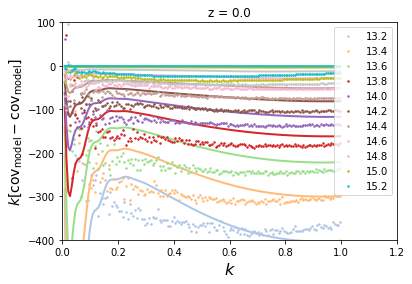

In [25]:

plt.figure()
for i in range(1,12):
    exc_cov = (cov_ex_3h[i]+cov_ex_2h[i]+cov_ex_1h[i])#*cosm.h**3)#/ (1.-iK_V_00[i])
    #exc_cov = (cov_ex_simple_2h[i]+cov_ex_simple_1h[i])#/(1.-iK_V_00[i])
    
    cov = (cov_model_3h[i]+cov_model_2h[i]+cov_model_1h[i])#/ (1.-iK_V_00[i])#+cov_new_2[i]
    plt.plot(k3[filt],k3[filt]*(covNmPk[i,filt]-cov),label="%.1f"%np.log10(m_av[i]),c=cmap(i/12.),marker='.',
             ls='',ms=3)
    plt.plot(k3[filt],k3[filt]*exc_cov,#*k3[filt],
             c=cmap(i/12.),lw=2)

plt.ylabel(r'$k\left[\mathrm{cov}_\mathrm{model} - \mathrm{cov}_\mathrm{model}\right]$',fontsize=14);
plt.xlabel(r'$k$',fontsize=16);
plt.legend()
plt.title('z = %.1f'%z);
plt.xlim([0,1.2])
plt.ylim([-400,100])
#plt.ylim([-0.00002,0.00005])